# Ant Colony Optimization for the Traveling Salesman Problem

This notebook implements an Ant Colony Optimization (ACO) algorithm to solve a variant of the Traveling Salesman Problem (TSP). The implementation allows for different configurations:
- Two sets of cities: 10 cities and 20 cities
- Four different ant agent counts: 1, 5, 10, and 20 ants

For each configuration, the algorithm runs for 50 iterations, and the pheromone map and optimal path are recorded at 10-iteration intervals.

In [12]:
import random
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

## Configuration Parameters for ACO

In [13]:
# --- Configuration Parameters for ACO ---
ALPHA = 1.0  # Pheromone influence
BETA = 3.0   # Heuristic (distance) influence
RHO = 0.3    # Pheromone evaporation rate
Q = 100      # Pheromone deposit factor (constant)
INITIAL_PHEROMONE = 0.1 # Initial pheromone level on all paths
NUM_ITERATIONS = 50

## Helper Functions

In [14]:
# --- Helper function to convert NumPy types for JSON serialization ---
def convert_numpy_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(i) for i in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_numpy_types(i) for i in obj)
    return obj

## Distance Matrix Generation

In [15]:
def generate_distance_matrix(num_cities):
    """Generates a symmetric distance matrix for a given number of cities.
    Distances are integers between 3 and 50 (inclusive).
    Distance from a city to itself is 0.
    """
    if num_cities <= 0:
        return np.array([])
    matrix = np.zeros((num_cities, num_cities), dtype=int)
    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            distance = random.randint(3, 50)
            matrix[i][j] = distance
            matrix[j][i] = distance
    return matrix

## ACO Algorithm Implementation

In [16]:
class ACO_TSP:
    def __init__(self, distances, num_ants, alpha, beta, rho, q, initial_pheromone):
        self.distances = distances
        self.num_cities = distances.shape[0]
        if self.num_cities == 0:
            raise ValueError("Distance matrix cannot be empty.")
        self.num_ants = num_ants
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.initial_pheromone = initial_pheromone

        self.pheromones = np.full((self.num_cities, self.num_cities), self.initial_pheromone, dtype=float)
        self.heuristic = 1.0 / (distances.astype(float) + np.finfo(float).eps)
        np.fill_diagonal(self.heuristic, 0)

        self.best_tour = None
        self.best_tour_length = float('inf')
        
        self.pheromone_progress = {}
        self.optimal_path_progress = {}

    def _select_next_city(self, current_city, visited_cities):
        probabilities = []
        unvisited_cities = [city for city in range(self.num_cities) if city not in visited_cities]

        if not unvisited_cities:
            return None

        total_prob_sum = 0.0
        for city in unvisited_cities:
            pheromone_val = self.pheromones[current_city, city] ** self.alpha
            heuristic_val = self.heuristic[current_city, city] ** self.beta
            prob = pheromone_val * heuristic_val
            probabilities.append((city, prob))
            total_prob_sum += prob

        if total_prob_sum == 0:
            return random.choice(unvisited_cities)
        
        probabilities = [(city, prob / total_prob_sum) for city, prob in probabilities]
        
        r = random.random()
        cumulative_prob = 0.0
        for city, prob in probabilities:
            cumulative_prob += prob
            if r <= cumulative_prob:
                return city
        return probabilities[-1][0]

    def _construct_tour(self, start_city):
        tour = [start_city]
        current_city = start_city
        visited_cities = {start_city}

        while len(tour) < self.num_cities:
            next_city = self._select_next_city(current_city, visited_cities)
            if next_city is None: break
            tour.append(next_city)
            visited_cities.add(next_city)
            current_city = next_city
        
        tour.append(start_city)
        return tour

    def _calculate_tour_length(self, tour):
        length = 0
        for i in range(len(tour) - 1):
            length += self.distances[tour[i], tour[i+1]]
        return int(length) # Ensure Python int

    def _update_pheromones(self, ant_tours):
        self.pheromones *= (1 - self.rho)
        for tour, tour_length in ant_tours:
            if tour_length == 0: continue # Avoid division by zero
            pheromone_deposit = self.q / tour_length
            for i in range(len(tour) - 1):
                city1, city2 = tour[i], tour[i+1]
                self.pheromones[city1, city2] += pheromone_deposit
                self.pheromones[city2, city1] += pheromone_deposit

    def run(self, num_iterations):
        iteration_best_lengths = []
        
        for iteration in range(1, num_iterations + 1):
            ant_tours = []
            current_iteration_best_tour = None
            current_iteration_best_length = float('inf')

            for _ in range(self.num_ants):
                start_city = random.randint(0, self.num_cities - 1)
                tour = self._construct_tour(start_city)
                tour_length = self._calculate_tour_length(tour)
                ant_tours.append((tour, tour_length))

                if tour_length < current_iteration_best_length:
                    current_iteration_best_length = tour_length
                    current_iteration_best_tour = tour
            
            self._update_pheromones(ant_tours)

            if current_iteration_best_length < self.best_tour_length:
                self.best_tour_length = current_iteration_best_length
                self.best_tour = current_iteration_best_tour
            
            iteration_best_lengths.append(self.best_tour_length)
            
            if iteration % 10 == 0:
                self.pheromone_progress[iteration] = self.pheromones.copy() # Store copy
                self.optimal_path_progress[iteration] = {
                    "path": self.best_tour,
                    "length": self.best_tour_length
                }
        
        return self.best_tour, self.best_tour_length, self.pheromone_progress, self.optimal_path_progress, iteration_best_lengths

## Generate Distance Matrices

In [17]:
print("--- Generating Distance Matrices ---")
distances_10 = generate_distance_matrix(10)
distances_20 = generate_distance_matrix(20)

print("\nDistance Matrix (10 cities):")
print(distances_10)

print("\nDistance Matrix (20 cities):")
print(distances_20)

--- Generating Distance Matrices ---

Distance Matrix (10 cities):
[[ 0 43 10  4 50 20 18 17 11 50]
 [43  0  9 46 50 37  8 40 30  5]
 [10  9  0  4  8 16 17 35 41  4]
 [ 4 46  4  0 38 15 48 44 47 37]
 [50 50  8 38  0 29 17 31 40 20]
 [20 37 16 15 29  0  3 13 47 30]
 [18  8 17 48 17  3  0 24 20 12]
 [17 40 35 44 31 13 24  0 16 24]
 [11 30 41 47 40 47 20 16  0  9]
 [50  5  4 37 20 30 12 24  9  0]]

Distance Matrix (20 cities):
[[ 0  8 27  9 25 25 41 19  5 49 32 37 10 27  8 38 21 43 42 26]
 [ 8  0 39 15 48  7  5 45 17 21  8 17  9 27 20 32 43 26 13 26]
 [27 39  0 25 16 45 20 47 46 44  7 41 43 13 37 49 18 13 32 27]
 [ 9 15 25  0 20 43 47 38 17 46 23  6 17  5 23 28 20  7 16 39]
 [25 48 16 20  0 48 23 16 44 34 28 44 32 12 19 11 18 50 38 37]
 [25  7 45 43 48  0 19 50 40 30 40 28 26 17 11 35 34  8  6 10]
 [41  5 20 47 23 19  0 12 43 13 46 30 41  7 27 27 41 32 36 19]
 [19 45 47 38 16 50 12  0 38  3 46 49 10 46 37 20 44 24 10 21]
 [ 5 17 46 17 44 40 43 38  0 30 13 32  3 49 49 19 35 14 35  9]
 [49 

## Visualize Distance Matrices

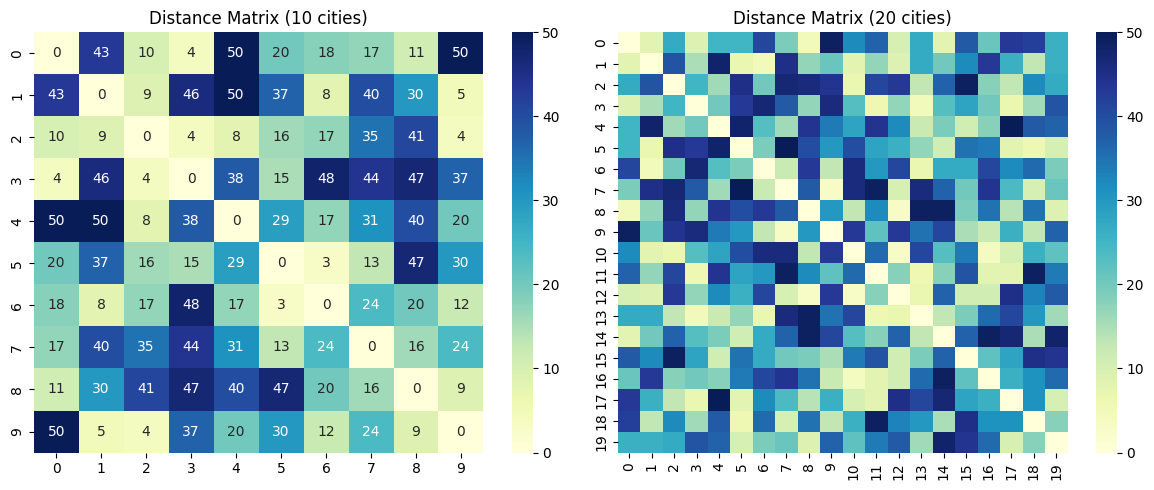

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(distances_10, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Distance Matrix (10 cities)")

plt.subplot(1, 2, 2)
sns.heatmap(distances_20, annot=False, cmap="YlGnBu")
plt.title("Distance Matrix (20 cities)")

plt.tight_layout()
plt.show()

## Run ACO Simulations

In [19]:
city_configs = [
    {"num_cities": 10, "distances": distances_10, "name": "10_cities"},
    {"num_cities": 20, "distances": distances_20, "name": "20_cities"}
]
ant_agent_counts = [1, 5, 10, 20]
all_results = {}
all_convergence_data = {}

for config in city_configs:
    num_cities = config["num_cities"]
    distances = config["distances"]
    config_name = config["name"]
    all_results[config_name] = {}
    all_convergence_data[config_name] = {}

    print(f"\n--- Running ACO for {num_cities} cities ---")
    for num_ants in ant_agent_counts:
        print(f"  Number of ants: {num_ants}")
        aco = ACO_TSP(distances=distances, 
                      num_ants=num_ants, 
                      alpha=ALPHA, 
                      beta=BETA, 
                      rho=RHO, 
                      q=Q, 
                      initial_pheromone=INITIAL_PHEROMONE)
        
        best_tour, best_length, pheromone_prog, path_prog, iteration_lengths = aco.run(NUM_ITERATIONS)
        
        all_results[config_name][str(num_ants)] = { # Ensure     for JSON
            "best_tour": best_tour,
            "best_length": best_length,
            "pheromone_progress_at_intervals": pheromone_prog,
            "optimal_path_progress_at_intervals": path_prog
        }
        
        all_convergence_data[config_name][str(num_ants)] = iteration_lengths

        print(f"    Best tour found: {best_tour}")
        print(f"    Best tour length: {best_length}")


--- Running ACO for 10 cities ---
  Number of ants: 1
    Best tour found: [9, 1, 6, 5, 7, 8, 0, 3, 2, 4, 9]
    Best tour length: 92
  Number of ants: 5
    Best tour found: [2, 3, 0, 8, 7, 5, 6, 1, 9, 4, 2]
    Best tour length: 92
  Number of ants: 10
    Best tour found: [2, 3, 0, 8, 7, 5, 6, 1, 9, 4, 2]
    Best tour length: 92
  Number of ants: 20
    Best tour found: [4, 2, 3, 0, 8, 7, 5, 6, 1, 9, 4]
    Best tour length: 92

--- Running ACO for 20 cities ---
  Number of ants: 1
    Best tour found: [6, 1, 5, 18, 7, 9, 15, 4, 14, 0, 8, 12, 10, 16, 11, 3, 17, 19, 2, 13, 6]
    Best tour length: 177
  Number of ants: 5
    Best tour found: [1, 6, 13, 3, 11, 16, 10, 12, 8, 19, 17, 2, 4, 15, 9, 7, 18, 5, 14, 0, 1]
    Best tour length: 161
  Number of ants: 10
    Best tour found: [5, 1, 6, 13, 3, 11, 16, 10, 12, 8, 0, 14, 18, 7, 9, 15, 4, 2, 17, 19, 5]
    Best tour length: 164
  Number of ants: 20
    Best tour found: [12, 10, 16, 11, 3, 13, 6, 1, 0, 14, 5, 18, 7, 9, 15, 4, 2, 17

## Visualize Convergence

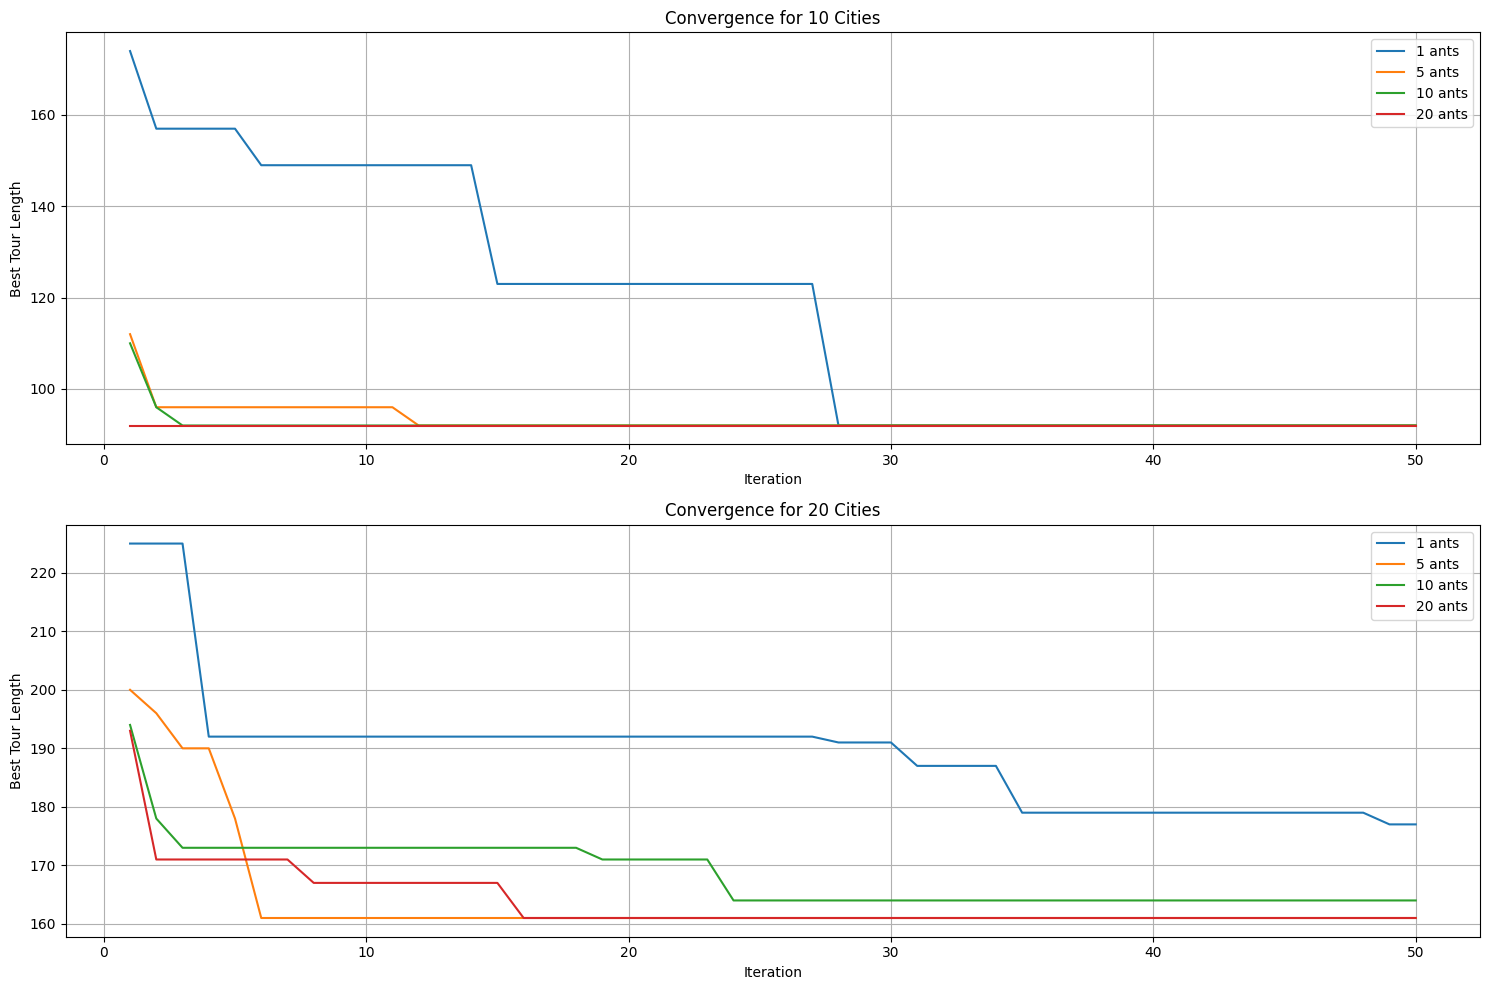

In [20]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
for ant_count, lengths in all_convergence_data["10_cities"].items():
    plt.plot(range(1, NUM_ITERATIONS + 1), lengths, label=f"{ant_count} ants")
plt.title("Convergence for 10 Cities")
plt.xlabel("Iteration")
plt.ylabel("Best Tour Length")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for ant_count, lengths in all_convergence_data["20_cities"].items():
    plt.plot(range(1, NUM_ITERATIONS + 1), lengths, label=f"{ant_count} ants")
plt.title("Convergence for 20 Cities")
plt.xlabel("Iteration")
plt.ylabel("Best Tour Length")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Visualize Pheromone Maps

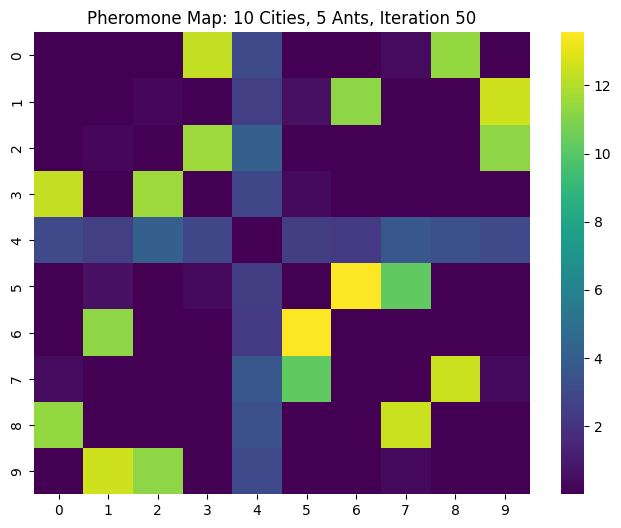

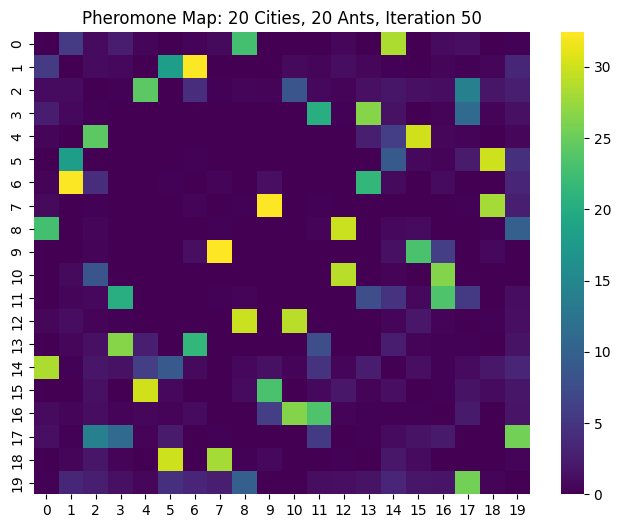

In [21]:
def plot_pheromone_map(pheromone_matrix, title):
    plt.figure(figsize=(8, 6))
    # Ensure data is a numpy array for heatmap, though seaborn often handles lists of lists
    # np should be imported at the top of the notebook
    sns.heatmap(np.array(pheromone_matrix), cmap="viridis")
    plt.title(title)
    plt.show()

# Example: Plot pheromone map for 10 cities with 5 ants at iteration 50
iter_key_to_plot = 50 # The iteration number we are interested in

try:
    # Try integer key first (for in-memory results from direct simulation run)
    pheromone_matrix_10_5_50 = all_results["10_cities"]["5"]["pheromone_progress_at_intervals"][iter_key_to_plot]
except KeyError:
    # If integer key fails, try string key (e.g., if results were loaded from a JSON file)
    pheromone_matrix_10_5_50 = all_results["10_cities"]["5"]["pheromone_progress_at_intervals"][str(iter_key_to_plot)]
plot_pheromone_map(pheromone_matrix_10_5_50, f"Pheromone Map: 10 Cities, 5 Ants, Iteration {iter_key_to_plot}")

# Example: Plot pheromone map for 20 cities with 20 ants at iteration 50
try:
    # Try integer key first
    pheromone_matrix_20_20_50 = all_results["20_cities"]["20"]["pheromone_progress_at_intervals"][iter_key_to_plot]
except KeyError:
    # If integer key fails, try string key
    pheromone_matrix_20_20_50 = all_results["20_cities"]["20"]["pheromone_progress_at_intervals"][str(iter_key_to_plot)]
plot_pheromone_map(pheromone_matrix_20_20_50, f"Pheromone Map: 20 Cities, 20 Ants, Iteration {iter_key_to_plot}")

## Summary of Results

In [22]:
print("Summary of Best Tour Lengths:")
print("\n10 Cities:")
for ant_count, result in all_results["10_cities"].items():
    print(f"  {ant_count} ants: {result['best_length']}")

print("\n20 Cities:")
for ant_count, result in all_results["20_cities"].items():
    print(f"  {ant_count} ants: {result['best_length']}")

Summary of Best Tour Lengths:

10 Cities:
  1 ants: 92
  5 ants: 92
  10 ants: 92
  20 ants: 92

20 Cities:
  1 ants: 177
  5 ants: 161
  10 ants: 164
  20 ants: 161
